# Tessellations Network

## 1.0 Introduction

Acquiring street network data is one of the main challenges in spatial analysis, particularly when conducting research in developing countries or rural areas. While several sources exist, such as Natural Earth and OpenStreetMap, each presents limitations. Natural Earth is suitable only for broad analyses, lacking the detail necessary for urban or neighborhood-level studies. On the other hand, OpenStreetMap relies heavily on user contributions, which can result in incomplete or outdated coverage, especially in less-mapped regions. To address these challenges, this notebook proposes a methodology for generating an initial approximation of a street network using the geometry of polygons. These polygons may represent city blocks, land parcels, or other bounded spatial units, providing a foundation for further spatial analysis when traditional network data is unavailable or insufficient.

## 2.0 Libraries

To interact with the database and process the various data, we have created a python script, `analysis.py`, which stores the different functions required for the task. In addition, other Python libraries are also used for data analysis and visualization.

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt

import os
import sys

module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)
import src.analysis as an

c:\Users\Laura\anaconda3\envs\ox_eafit\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 3.0 Initial data

The main input to create an initial approximation of a street network is a set of polygons. In this case, we selected a neighborhood in Medellín called Moravia. This neighborhood is characterized as a low-income area that has experienced informal occupation over the past several years, gradually consolidating into a natural street network. Due to this informality, the available information is often uncertain or even nonexistent. Additionally, besides the polygons representing the city blocks, it is necessary to include the polygon of the river that crosses the study area, as its omission would lead to inconsistencies in the tessellations generated near the blocks adjacent to the river.

We start by defining an analysis zone, which will be considered as a 500-meter buffer surrounding the neighborhood blocks to capture a wider space and selecting all the city blocks that intersect this buffer.

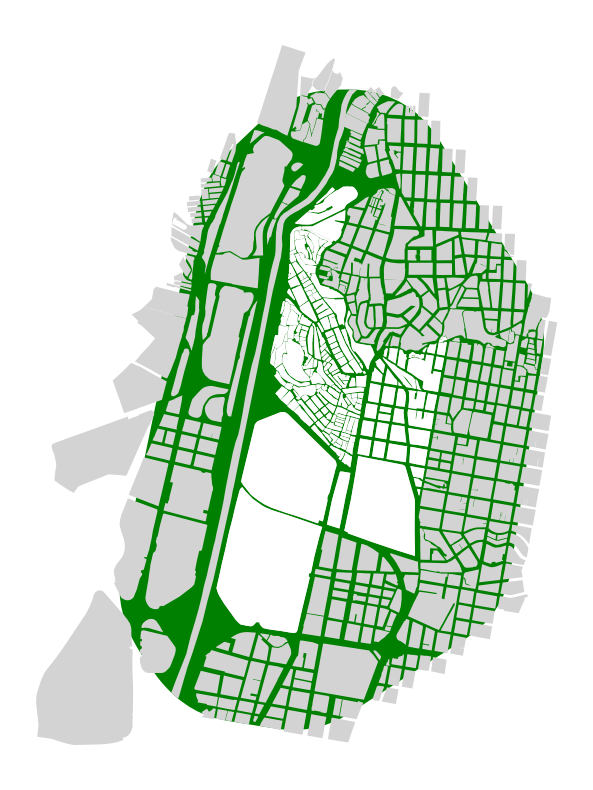

In [2]:
# Initial blocks
zone_blocks = gpd.read_file('../data/output/shape/zone_blocks/moravia_LH/moravia_LH_blocks.shp')
zone_blocks = zone_blocks.to_crs('epsg:32618')

# Generate the expanded polygon of the analysis area using a buffer.
poligono_ampliado = zone_blocks.union_all().convex_hull.buffer(500)
poligono_ampliado_gdf = gpd.GeoDataFrame(geometry=gpd.GeoSeries([poligono_ampliado]), crs=zone_blocks.crs)

# Select all the blocks in the territory that intersects the expanded polygon.
blocks = gpd.read_file('../data/output/shape/blocks/medellin_blocks.shp')
blocks = blocks.rename(columns = {'MANZ_CCNCT':'block_id'})
blocks = blocks.to_crs('epsg:32618')
blocks = blocks[['block_id','geometry']]
blocks = blocks[blocks.geometry.intersects(poligono_ampliado)]

# Add the section of the river clipped by the analysis area polygon.
rio = gpd.read_file('../data/input/shape/rio_medellin/rio_medellin.shp')
rio = rio.to_crs('epsg:32618')
data_rio = {'block_id':'0','geometry':rio.loc[0,'geometry']}
rio_gdf = gpd.GeoDataFrame([data_rio], crs=blocks.crs)
rio_truncado_gdf = poligono_ampliado_gdf.overlay(rio_gdf, how='intersection')
blocks = gpd.pd.concat([blocks, rio_truncado_gdf], ignore_index=True)

f, ax = plt.subplots(figsize=(10, 10))
poligono_ampliado_gdf.plot(ax=ax, color='green', zorder=1)
blocks.plot(ax=ax, color='lightgray', zorder=2)
zone_blocks.plot(ax=ax, color='w', zorder=3)
ax.set_axis_off()
plt.show()

We can inspect the geodataframe blocks to check that every entry is a Polygon:

In [3]:
# Verify that all geometries are Polygons
blocks.geom_type.unique()

array(['Polygon'], dtype=object)

This check ensures that all entries are of type `Polygon`. If the output includes other geometry types (e.g., `MultiPolygon`, `LineString`), you should review and clean the data before proceeding.

## 4.0 Street network from morphological tessellations

The next step is to define a morphological tessellation based on the initial polygons using the `network_from_tessellation` function. A morphological tessellation is an extension of the Voronoi principle adapted for polygons. Morphological tessellation results in polygons that are generated around polygons instead of being generated around points. These tessellation polygons have the particular characteristic of being equidistant from the edges of the input polygons, similar to how point-based Voronoi diagrams are equidistant from each point. This procedure is performed with the `momepy` library.

Once the morphological tessellations are generated, we extract their boundaries by dissolving the polygon geometries into lines and nodes. These lines and nodes represent the streets and intersections of the resulting network. Before further processing, the resulting GeoDataFrames must be organized using the `network_entities` function, which give an OpenStreetMap formatting to lines and nodes. In this step, nodes are assigned unique identifiers and lines are transformed to edges by labeling based on their origin and destination nodes to ensure a proper graph structure. Finally, the network is consolidated using the `osmnx` library, which helps to merge nodes that are located too close to each other.

In [4]:
blocks = blocks.set_index('block_id')
nodes, edges = an.network_from_tessellation(blocks, blocks.crs, (True, 5))

Creating tessellation...
Converting polygons to lines...
Extracting points from lines...
Creating nodes and edges...
Creating unique ids (osmid) for nodes based on coordinates...
Creating unique ids (u,v) for edges based on coordinates...
Removing redundant nodes...
Resolving indexes u, v, key...
Creating graph...
Consolidating graph using tolerance of 5 meters...
Formating nodes and edges...


## 5.0 Results

The resulting edges and nodes constitute a preliminar street network from the analyzed polygons:

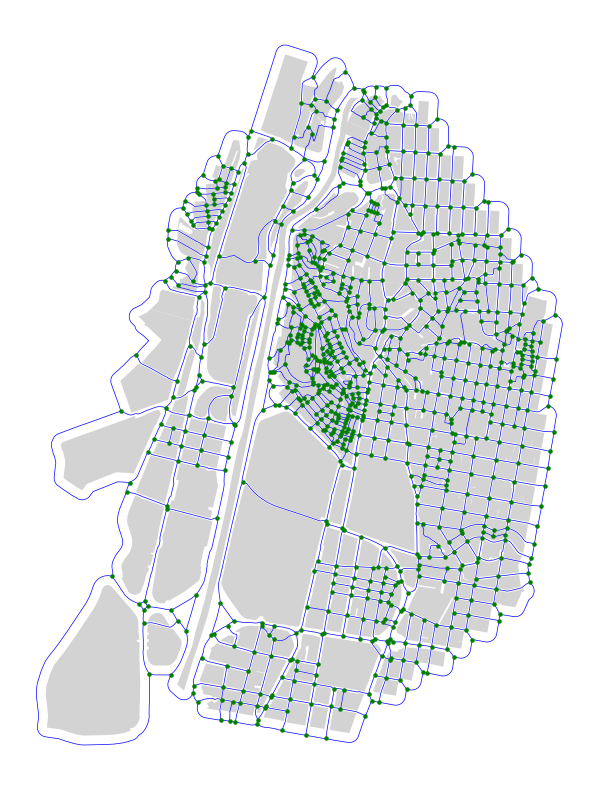

In [5]:
f, ax = plt.subplots(figsize=(10, 10))
blocks.plot(ax=ax, color='lightgray', zorder=1)
nodes.plot(ax=ax, color='green', markersize=5, zorder=3)
edges.plot(ax=ax, color='blue', linewidth=0.5, zorder=2)
ax.set_axis_off()
plt.show()

If we zoom in on the informal settlements of Moravia, the area in the preliminary map with the highest concentration of nodes, we can observe that the street network resulting from the morphological tessellation preserves the structure of the initial blocks.

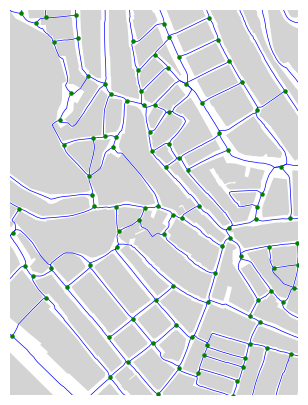

In [6]:
f, ax = plt.subplots(figsize=(5, 5))
blocks.plot(ax=ax, color='lightgray', zorder=1)
nodes.plot(ax=ax, color='green', markersize=5, zorder=3)
edges.plot(ax=ax, color='blue', linewidth=0.5, zorder=2)
ax.set_axis_off()
ax.set_xlim(437193, 437533)
ax.set_ylim(693551, 694005)
plt.show()

We can print the nodes and edges to inspect their formatting in OpenStreetMap style.

In [7]:
edges.head()

level_0  \
u                v                key            
4362278169275706 4363036469320545 0          0   
                 4363699169261235 0          2   
4363036469320545 4363193969325318 0          6   
                 4365169469313060 0          7   
4364244769224107 4362278169275706 0          1   

                                                                                geometry  \
u                v                key                                                      
4362278169275706 4363036469320545 0    LINESTRING (436227.813 692757.069, 436228.609 ...   
                 4363699169261235 0    LINESTRING (436227.813 692757.069, 436233.193 ...   
4363036469320545 4363193969325318 0    LINESTRING (436303.644 693205.458, 436303.699 ...   
                 4365169469313060 0    LINESTRING (436303.644 693205.458, 436350.771 ...   
4364244769224107 4362278169275706 0    LINESTRING (436424.476 692241.08, 436424.974 6...   

                                            length  
u                v                key               
4362278169275706 4363036469320545 0     476.691420  
                 4363699169261235 0     208.482061  
4363036469320545 4363193969325318 0      50.499794  
                 4365169469313060 0     226.783580  
4364244769224107 4362278169275706 0    1887.739419

In [8]:
nodes.head()

,streets_count,x,y,street_count,geometry
osmid,,,,,
4362278169275706,3.0,436227.813035,692757.068886,0,POINT (436227.813 692757.069)
4363036469320545,3.0,436303.643745,693205.458154,0,POINT (436303.644 693205.458)
4364244769224107,3.0,436424.476425,692241.079568,0,POINT (436424.476 692241.08)
4363699169261235,3.0,436369.918078,692612.356606,0,POINT (436369.918 692612.357)
4362737869363267,3.0,436273.783603,693632.675860,0,POINT (436273.784 693632.676)
